---
# Chat with Your Documents using LLMs
---

**LangChain 🦜️🔗  + Vertex AI PaLM API + Matching Engine**

---

| | |
|----------|-------------|
| Author(s)   | Rajesh Thallam (rthallam@) |
| Last updated | 05/12/2023 |

<br/>

| Release Notes||
|----------|-------------|
| Date   | Description |
| 05/12/2023 | Initial version |

---




## Objective

This notebook demonstrates how you can improve LLM's response by augmenting LLM's knowledge with external data sources such as documents, websites. This technique is commonly referred to as Retrieval-Augmented Generation. This approach retrieves relevant data from knowledge bases outside the LLM and augments the retrieved data with context in the prompt to the LLM.  We demonstrate the application using Vertex AI PaLM APIs, Matching Engine and LangChain  🦜️🔗 .

## High Level Flow

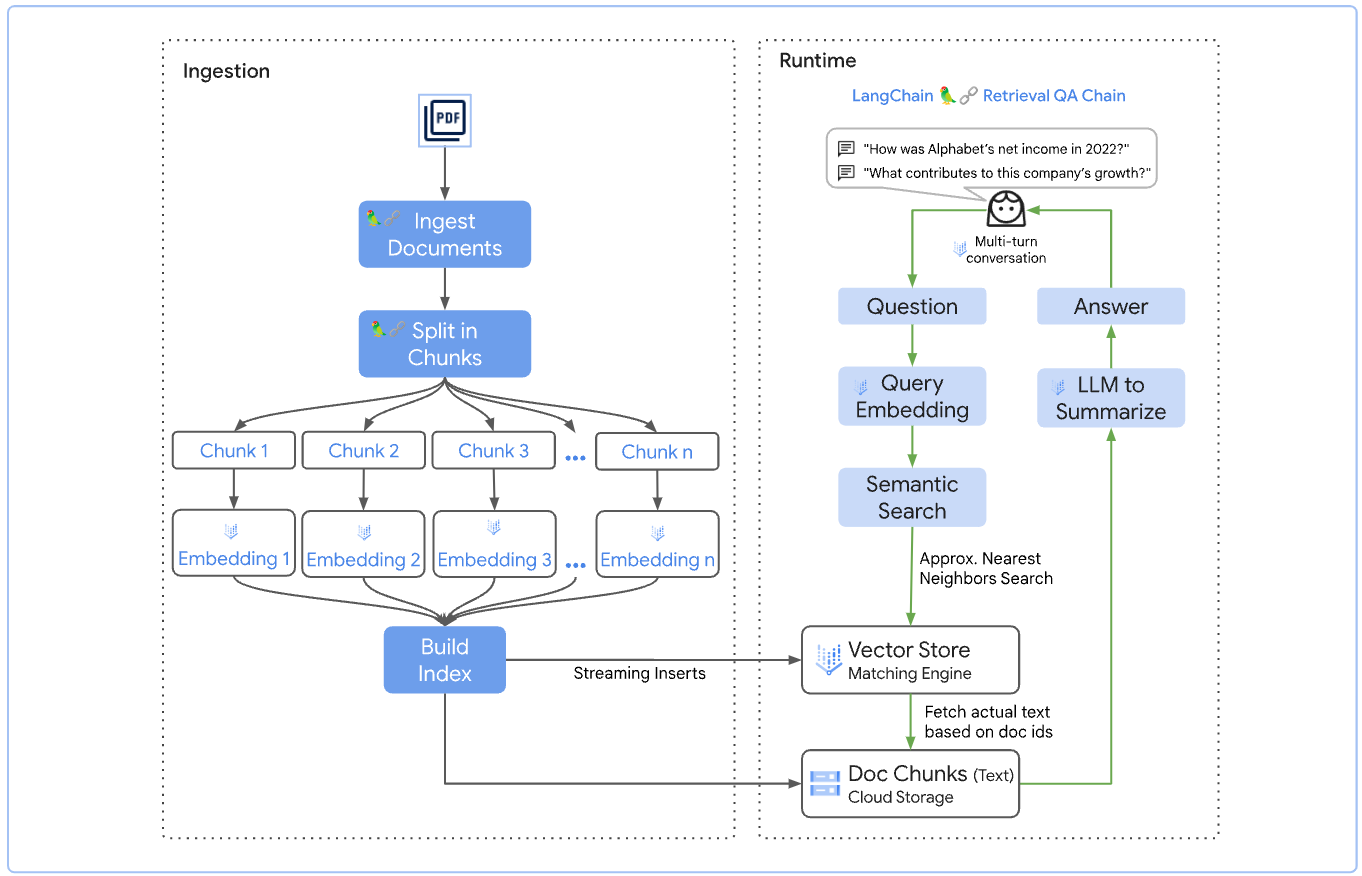


Following is the high-level flow at runtime when user prompts the model:
- User enters a prompt or asks a question as a prompt
- Generated embedding for the user prompt to capture semantics
- Search the vector store to retrieve the nearest embeddings (relevant documents) closer to the prompt
- Fetch the actual text for the retrieved embeddings to add as context to the user's prompt
- Add the retrieved documents as context to the user's prompt
- Send the updated prompt to the LLM
- Return a summarized response to the user with references to the sources from the knowledge base

Following are the sequence of tasks when ingesting knowledge base sources into the vector store:
- Read the documents (PDF files in this notebook)
- Chunk the documents  to include relevant parts of the document as context to the prompt
- Generate embeddings for each chunked document
- Add embedding to the vector store

In this notebook, we use:
- ✅ Vertex PaLM Text and Chat APIs for LLM
- ✅ Vertex Embeddings API to generate embeddings to capture semantics
- ✅ [Vertex AI Matching Engine](https://cloud.google.com/vertex-ai/docs/matching-engine/overview) as a managed vector store on cloud to store the generated embeddings
- ✅ [Langchain](https://langchain.com/) to orchestrate the flow (or chain the tasks)

## Costs

This tutorial uses billable components of Google Cloud Platform (GCP):

-   [Vertex AI Matching Engine](https://cloud.google.com/vertex-ai/pricing#matchingengine)
-   [Vertex AI Workbench [optional]](https://cloud.google.com/vertex-ai-workbench)
-   [Cloud Storage](https://cloud.google.com/storage)

Learn about [Vertex AI Pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage Pricing](https://cloud.google.com/storage/pricing) to generate a cost estimate based on your projected usage.

---

## Install dependencies

In [ ]:
# Install Vertex AI LLM SDK# Install Vertex AI LLM SDK
! pip install google-cloud-aiplatform==1.25.0

! pip install "shapely<2.0.0"
! pip install protobuf==3.20.3

# Install langchain
! pip install langchain

# PDF loader
! pip install pypdf

# For default embeddings
! pip install tensorflow_hub tensorflow_text

---

#### ⚠️ Do not forget to click the "RESTART RUNTIME" button above.

---

In [92]:
# # Authenticate with Google Cloud credentials
# from google.colab import auth as google_auth
# google_auth.authenticate_user()

import logging
logging.basicConfig(level = logging.INFO)

import numpy as np

In [93]:
PROJECT_ID = "axel-argolis-1"  # @param {type:"string"}
REGION = "us-central1"  # @param {type:"string"}
STAGING_GCS_BUCKET = "gs://axel-argolis-usc1-bucket/matching-engine/langchain" # @param {type:"string"}

In [94]:
import langchain
print(f"LangChain version: {langchain.__version__}")

from google.cloud import aiplatform
print(f"Vertex AI SDK version: {aiplatform.__version__}")

# Initialize Vertex AI SDK
import vertexai
vertexai.init(project=PROJECT_ID, location=REGION)

LangChain version: 0.0.194
Vertex AI SDK version: 1.26.0


## LangChain Wrappers and Utilities

**Run the following cells**

In [95]:
# @title Vertex AI LLM wrapper for using with Langchain
# Credits:
#  kuligin@      - Main contributor to LangChain + Vertex PaLM API integration
#  tomaspiaggio@ - Main contributor to LangChain + Vertex Matching Engine integration
# Note:
# - 04/19: Eventually this wrapper will be replaced by official Langchain + Vertex AI integration

import time
from typing import Any, Mapping, List, Dict, Optional, Tuple, Union
from dataclasses import dataclass, field

from pydantic import BaseModel, Extra, root_validator

from langchain.llms.base import LLM
from langchain.embeddings.base import Embeddings
from langchain.chat_models.base import BaseChatModel
from langchain.llms.utils import enforce_stop_tokens
from langchain.schema import Generation, LLMResult
from langchain.schema import AIMessage, BaseMessage, ChatGeneration, ChatResult, HumanMessage, SystemMessage

from vertexai.preview.language_models import TextGenerationResponse, ChatSession


def rate_limit(max_per_minute):
  period = 60 / max_per_minute
  print('Waiting')
  while True:
    before = time.time()
    yield
    after = time.time()
    elapsed = after - before
    sleep_time = max(0, period - elapsed)
    if sleep_time > 0:
      print('.', end='')
      time.sleep(sleep_time)


class _VertexCommon(BaseModel):
    """Wrapper around Vertex AI large language models.

    To use, you should have the
    ``google.cloud.aiplatform.private_preview.language_models`` python package
    installed.
    """
    client: Any = None #: :meta private:
    model_name: str = "text-bison@001"
    """Model name to use."""

    temperature: float = 0.2
    """What sampling temperature to use."""

    top_p: int = 0.8
    """Total probability mass of tokens to consider at each step."""

    top_k: int = 40
    """The number of highest probability tokens to keep for top-k filtering."""

    max_output_tokens: int = 200
    """The maximum number of tokens to generate in the completion."""

    @property
    def _default_params(self) -> Mapping[str, Any]:
        """Get the default parameters for calling Vertex AI API."""
        return {
            "temperature": self.temperature,
            "top_p": self.top_p,
            "top_k": self.top_k,
            "max_output_tokens": self.max_output_tokens
        }

    def _predict(self, prompt: str, stop: Optional[List[str]]) -> str:
        res = self.client.predict(prompt, **self._default_params)
        return self._enforce_stop_words(res.text, stop)

    def _enforce_stop_words(self, text: str, stop: Optional[List[str]]) -> str:
        if stop:
            return enforce_stop_tokens(text, stop)
        return text

    @property
    def _llm_type(self) -> str:
        """Return type of llm."""
        return "vertex_ai"

class VertexLLM(_VertexCommon, LLM):
    model_name: str = "text-bison@001"

    @root_validator()
    def validate_environment(cls, values: Dict) -> Dict:
        """Validate that the python package exists in environment."""
        try:
            from vertexai.preview.language_models import TextGenerationModel
        except ImportError:
            raise ValueError(
                "Could not import Vertex AI LLM python package. "
            )

        try:
            values["client"] = TextGenerationModel(values["model_name"], 
                                                  endpoint_name=f'projects/{PROJECT_ID}/locations/{REGION}/publishers/google/models/{values["model_name"]}')
        except AttributeError:
            raise ValueError(
                "Could not set Vertex Text Model client."
            )

        return values

    def _call(self, prompt: str, stop: Optional[List[str]] = None) -> str:
        """Call out to Vertex AI's create endpoint.

        Args:
            prompt: The prompt to pass into the model.

        Returns:
            The string generated by the model.
        """
        return self._predict(prompt, stop)


@dataclass
class _MessagePair:
    """InputOutputTextPair represents a pair of input and output texts."""

    question: HumanMessage
    answer: AIMessage


@dataclass
class _ChatHistory:
    """InputOutputTextPair represents a pair of input and output texts."""

    history: List[_MessagePair] = field(default_factory=list)
    system_message: Optional[SystemMessage] = None


def _parse_chat_history(history: List[BaseMessage]) -> _ChatHistory:
    """Parses a sequence of messages into history.

    A sequency should be either (SystemMessage, HumanMessage, AIMessage,
    HumanMessage, AIMessage, ...) or (HumanMessage, AIMessage, HumanMessage,
    AIMessage, ...).
    """
    if not history:
        return _ChatHistory()
    first_message = history[0]
    system_message = first_message if isinstance(first_message, SystemMessage) else None
    chat_history = _ChatHistory(system_message=system_message)
    messages_left = history[1:] if system_message else history
    # if len(messages_left) % 2 != 0:
    #     raise ValueError(
    #         f"Amount of messages in history should be even, got {len(messages_left)}!"
    #     )
    for question, answer in zip(messages_left[::2], messages_left[1::2]):
        if not isinstance(question, HumanMessage) or not isinstance(answer, AIMessage):
            raise ValueError(
                "A human message should follow a bot one, "
                f"got {question.type}, {answer.type}."
            )
        chat_history.history.append(_MessagePair(question=question, answer=answer))
    return chat_history


class _VertexChatCommon(_VertexCommon):
    """Wrapper around Vertex AI Chat large language models.

    To use, you should have the
    ``vertexai.preview.language_models`` python package
    installed.
    """
    model_name: str = "chat-bison@001"
    """Model name to use."""

    @root_validator()
    def validate_environment(cls, values: Dict) -> Dict:
        """Validate that the python package exists in environment."""
        try:
            from vertexai.preview.language_models import ChatModel
        except ImportError:
            raise ValueError(
                "Could not import Vertex AI LLM python package. "
            )

        try:
            values["client"] = ChatModel(values["model_name"],
                                         endpoint_name=f'projects/{PROJECT_ID}/locations/{REGION}/publishers/google/models/{values["model_name"]}')
        except AttributeError:
            raise ValueError(
                "Could not set Vertex Text Model client."
            )

        return values

    def _response_to_chat_results(
        self, response: TextGenerationResponse, stop: Optional[List[str]]
    ) -> ChatResult:
        text = self._enforce_stop_words(response.text, stop)
        return ChatResult(generations=[ChatGeneration(message=AIMessage(content=text))])


class VertexChat(_VertexChatCommon, BaseChatModel):
    """Wrapper around Vertex AI large language models.

    To use, you should have the
    ``vertexai.preview.language_models`` python package
    installed.
    """

    model_name: str = "chat-bison@001"
    chat: Any = None  #: :meta private:

    def send_message(
        self, message: Union[HumanMessage, str], stop: Optional[List[str]] = None
    ) -> ChatResult:
        text = message.content if isinstance(message, BaseMessage) else message
        response = self.chat.send_message(text)
        text = self._enforce_stop_words(response.text, stop)
        return ChatResult(generations=[ChatGeneration(message=AIMessage(content=text))])

    def _generate(
        self, messages: List[BaseMessage], stop: Optional[List[str]] = None
    ) -> ChatResult:
        if not messages:
            raise ValueError(
                "You should provide at least one message to start the chat!"
            )
        question = messages[-1]
        if not isinstance(question, HumanMessage):
            raise ValueError(
                f"Last message in the list should be from human, got {question.type}."
            )
        self.start_chat(messages[:-1])
        return self.send_message(question)

    def start_chat(self, messages: List[BaseMessage]) -> None:
        """Starts a chat."""
        history = _parse_chat_history(messages)
        context = history.system_message.content if history.system_message else None
        self.chat = self.client.start_chat(context=context, **self._default_params)
        for pair in history.history:
            self.chat._history.append((pair.question.content, pair.answer.content))

    def clear_chat(self) -> None:
        self.chat = None

    @property
    def history(self) -> List[BaseMessage]:
        """Chat history."""
        history: List[BaseMessage] = []
        if self.chat:
            for question, answer in self.chat._history:
                history.append(HumanMessage(content=question))
                history.append(AIMessage(content=answer))
        return history

    async def _agenerate(
        self, messages: List[BaseMessage], stop: Optional[List[str]] = None
    ) -> ChatResult:
        raise NotImplementedError(
            """Vertex AI doesn't support async requests at the moment."""
        )

class VertexMultiTurnChat(_VertexChatCommon, BaseChatModel):
    """Wrapper around Vertex AI large language models."""

    model_name: str = "chat-bison@001"
    chat: Optional[ChatSession] = None

    def clear_chat(self) -> None:
        self.chat = None

    def start_chat(self, message: Optional[SystemMessage] = None) -> None:
        if self.chat:
            raise ValueError("Chat has already been started. Please, clear it first.")
        if message and not isinstance(message, SystemMessage):
            raise ValueError("Context should be a system message")
        context = message.content if message else None
        self.chat = self.client.start_chat(context=context, **self._default_params)

    @property
    def history(self) -> List[Tuple[str]]:
        """Chat history."""
        if self.chat:
            return self.chat._history
        return []

    def _generate(
        self, messages: List[BaseMessage], stop: Optional[List[str]] = None
    ) -> ChatResult:
        if len(messages) != 1:
            raise ValueError(
                "You should send exactly one message to the chat each turn."
            )
        if not self.chat:
            raise ValueError("You should start_chat first!")
        response = self.chat.send_message(messages[0].content)
        return self._response_to_chat_results(response, stop=stop)

    async def _agenerate(
        self, messages: List[BaseMessage], stop: Optional[List[str]] = None
    ) -> ChatResult:
        raise NotImplementedError(
            """Vertex AI doesn't support async requests at the moment."""
        )

class VertexEmbeddings(Embeddings, BaseModel):
    """Wrapper around Vertex AI large language models embeddings API.

    To use, you should have the
    ``google.cloud.aiplatform.private_preview.language_models`` python package
    installed.
    """
    model_name: str = "textembedding-gecko@001"
    """Model name to use."""

    model: Any
    requests_per_minute: int = 15


    @root_validator()
    def validate_environment(cls, values: Dict) -> Dict:
        """Validate that the python package exists in environment."""
        try:
            from vertexai.preview.language_models import TextEmbeddingModel

        except ImportError:
            raise ValueError(
                "Could not import Vertex AI LLM python package. "
            )

        try:
            values["model"] = TextEmbeddingModel(values["model_name"],
                                                 endpoint_name=f'projects/{PROJECT_ID}/locations/{REGION}/publishers/google/models/{values["model_name"]}')

        except AttributeError:
            raise ValueError(
                "Could not set Vertex Text Model client."
            )

        return values

    class Config:
        """Configuration for this pydantic object."""

        extra = Extra.forbid

    def embed_documents(self, texts: List[str]) -> List[List[float]]:
      """Call Vertex LLM embedding endpoint for embedding docs
      Args:
          texts: The list of texts to embed.
      Returns:
          List of embeddings, one for each text.
      """
      
      limiter = rate_limit(self.requests_per_minute)
      results = []
      docs = list(texts)

      while docs:
        # Working in batches of 2 because the API apparently won't let
        # us send more than 2 documents per request to get embeddings.
        head, docs = docs[:2], docs[2:]
        # print(f'Sending embedding request for: {head!r}')
        chunk = self.model.get_embeddings(head)
        results.extend(chunk)
        next(limiter)

      return [r.values for r in results]

    def embed_query(self, text: str) -> List[float]:
      """Call Vertex LLM embedding endpoint for embedding query text.
      Args:
        text: The text to embed.
      Returns:
        Embedding for the text.
      """
      single_result = self.embed_documents([text])
      return single_result[0]

In [96]:
# @title Vertex Matching Engine implementation of the vector store in LangChain
# Ref: https://github.com/hwchase17/langchain/pull/3350
# 04/27/2023: Replace with langchain apis after the PR is merged

"""Vertex Matching Engine implementation of the vector store."""
from __future__ import annotations

import json
import logging
import time
import uuid
from typing import TYPE_CHECKING, Any, Iterable, List, Optional, Type

from langchain.docstore.document import Document
from langchain.embeddings import TensorflowHubEmbeddings
from langchain.embeddings.base import Embeddings
from langchain.vectorstores.base import VectorStore

from google.cloud import storage
from google.cloud.aiplatform import MatchingEngineIndex, MatchingEngineIndexEndpoint
from google.cloud import aiplatform_v1
from google.oauth2.service_account import Credentials
import google.auth
import google.auth.transport.requests

logger = logging.getLogger()


class MatchingEngine(VectorStore):
    """Vertex Matching Engine implementation of the vector store.

    While the embeddings are stored in the Matching Engine, the embedded
    documents will be stored in GCS.

    An existing Index and corresponding Endpoint are preconditions for
    using this module.

    See usage in docs/modules/indexes/vectorstores/examples/matchingengine.ipynb

    Note that this implementation is mostly meant for reading if you are
    planning to do a real time implementation. While reading is a real time
    operation, updating the index takes close to one hour."""

    def __init__(
        self,
        project_id: str,
        region: str,
        index: MatchingEngineIndex,
        endpoint: MatchingEngineIndexEndpoint,
        embedding: Embeddings,
        gcs_client: storage.Client,
        index_client: aiplatform_v1.IndexServiceClient,
        index_endpoint_client: aiplatform_v1.IndexEndpointServiceClient,
        gcs_bucket_name: str,
        credentials: Credentials = None,
    ):
        """Vertex Matching Engine implementation of the vector store.

        While the embeddings are stored in the Matching Engine, the embedded
        documents will be stored in GCS.

        An existing Index and corresponding Endpoint are preconditions for
        using this module.

        See usage in
        docs/modules/indexes/vectorstores/examples/matchingengine.ipynb.

        Note that this implementation is mostly meant for reading if you are
        planning to do a real time implementation. While reading is a real time
        operation, updating the index takes close to one hour.

        Attributes:
            project_id: The GCS project id.
            index: The created index class. See
            ~:func:`MatchingEngine.from_components`.
            endpoint: The created endpoint class. See
            ~:func:`MatchingEngine.from_components`.
            embedding: A :class:`Embeddings` that will be used for
            embedding the text sent. If none is sent, then the
            multilingual Tensorflow Universal Sentence Encoder will be used.
            gcs_client: The Google Cloud Storage client.
            credentials (Optional): Created GCP credentials.
        """
        super().__init__()
        self._validate_google_libraries_installation()

        self.project_id = project_id
        self.region = region
        self.index = index
        self.endpoint = endpoint
        self.embedding = embedding
        self.gcs_client = gcs_client
        self.index_client = index_client
        self.index_endpoint_client = index_endpoint_client
        self.gcs_client = gcs_client
        self.credentials = credentials
        self.gcs_bucket_name = gcs_bucket_name

    def _validate_google_libraries_installation(self) -> None:
        """Validates that Google libraries that are needed are installed."""
        try:
            from google.cloud import aiplatform, storage  # noqa: F401
            from google.oauth2 import service_account  # noqa: F401
        except ImportError:
            raise ImportError(
                "You must run `pip install --upgrade "
                "google-cloud-aiplatform google-cloud-storage`"
                "to use the MatchingEngine Vectorstore."
            )

    def add_texts(
        self,
        texts: Iterable[str],
        metadatas: Optional[List[dict]] = None,
        **kwargs: Any,
    ) -> List[str]:
        """Run more texts through the embeddings and add to the vectorstore.

        Args:
            texts: Iterable of strings to add to the vectorstore.
            metadatas: Optional list of metadatas associated with the texts.
            kwargs: vectorstore specific parameters.

        Returns:
            List of ids from adding the texts into the vectorstore.
        """
        logger.debug("Embedding documents.")
        embeddings = self.embedding.embed_documents(list(texts))
        insert_datapoints_payload = []
        ids = []

        # Streaming index update
        for idx, (embedding, text) in enumerate(zip(embeddings, texts)):
            id = uuid.uuid4()
            self._upload_to_gcs(text, f"documents/{id}")
            insert_datapoints_payload.append(aiplatform_v1.IndexDatapoint(
                datapoint_id=str(id),
                feature_vector=embedding))
            if idx %100 == 0:
                upsert_request = aiplatform_v1.UpsertDatapointsRequest(
                    index=self.index.name,
                    datapoints=insert_datapoints_payload
                )
                response = self.index_client.upsert_datapoints(request=upsert_request)
                insert_datapoints_payload = []

        upsert_request = aiplatform_v1.UpsertDatapointsRequest(
            index=self.index.name,
            datapoints=insert_datapoints_payload
        )
        response = self.index_client.upsert_datapoints(request=upsert_request)

        logger.debug("Updated index with new configuration.")

        return ids

    def _upload_to_gcs(self, data: str, gcs_location: str) -> None:
        """Uploads data to gcs_location.

        Args:
            data: The data that will be stored.
            gcs_location: The location where the data will be stored.
        """
        bucket = self.gcs_client.get_bucket(self.gcs_bucket_name)
        blob = bucket.blob(gcs_location)
        blob.upload_from_string(data)


    def get_matches(
            self,
            embeddings: List[str],
            n_matches: int,
            index_endpoint: MatchingEngineIndexEndpoint) -> str:
        '''
        get matches from matching engine given a vector query
        Uses public endpoint

        '''
        import requests
        import json
        from typing import List

        request_data = {"deployed_index_id": index_endpoint.deployed_indexes[0].id,
                        "queries": [
                            {
                                "datapoint": {
                                    "datapoint_id": f"{i}",
                                    "feature_vector": emb
                                },
                                "neighbor_count": n_matches
                            }
                            for i, emb in enumerate(embeddings)]
                        }

        endpoint_address = self.endpoint.public_endpoint_domain_name
        rpc_address = f'https://{endpoint_address}/v1beta1/{index_endpoint.resource_name}:findNeighbors'
        endpoint_json_data = json.dumps(request_data)

        logger.debug(f"Querying Matching Engine Index Endpoint {rpc_address}")

        header = {'Authorization': 'Bearer ' + self.credentials.token}

        return requests.post(rpc_address, data=endpoint_json_data, headers=header)

    def similarity_search(
        self, query: str, k: int = 4, **kwargs: Any
    ) -> List[Document]:
        """Return docs most similar to query.

        Args:
            query: The string that will be used to search for similar documents.
            k: The amount of neighbors that will be retrieved.

        Returns:
            A list of k matching documents.
        """

        logger.debug(f"Embedding query {query}.")
        embedding_query = self.embedding.embed_documents([query])
        deployed_index_id = self._get_index_id()
        logger.debug(f"Deployed Index ID = {deployed_index_id}")

        # TO-DO: Pending query sdk integration
        # response = self.endpoint.match(
        #     deployed_index_id=self._get_index_id(),
        #     queries=embedding_query,
        #     num_neighbors=k,
        # )

        response = self.get_matches(embedding_query,
                                    k,
                                    self.endpoint)

        if response.status_code == 200:
            response = response.json()["nearestNeighbors"]
        else:
            raise Exception(f"Failed to query index {str(response)}")

        if len(response) == 0:
            return []

        logger.debug(f"Found {len(response)} matches for the query {query}.")

        results = []

        # I'm only getting the first one because queries receives an array
        # and the similarity_search method only recevies one query. This
        # means that the match method will always return an array with only
        # one element.
        for doc in response[0]["neighbors"]:
            page_content = self._download_from_gcs(f"documents/{doc['datapoint']['datapointId']}")
            results.append(Document(page_content=page_content))

        logger.debug("Downloaded documents for query.")

        return results

    def _get_index_id(self) -> str:
        """Gets the correct index id for the endpoint.

        Returns:
            The index id if found (which should be found) or throws
            ValueError otherwise.
        """
        for index in self.endpoint.deployed_indexes:
            if index.index == self.index.name:
                return index.id

        raise ValueError(
            f"No index with id {self.index.name} "
            f"deployed on enpoint "
            f"{self.endpoint.display_name}."
        )

    def _download_from_gcs(self, gcs_location: str) -> str:
        """Downloads from GCS in text format.

        Args:
            gcs_location: The location where the file is located.

        Returns:
            The string contents of the file.
        """
        bucket = self.gcs_client.get_bucket(self.gcs_bucket_name)
        try:
            blob = bucket.blob(gcs_location)
            return blob.download_as_string()
        except Exception as e:
            return ''

    @classmethod
    def from_texts(
        cls: Type["MatchingEngine"],
        texts: List[str],
        embedding: Embeddings,
        metadatas: Optional[List[dict]] = None,
        **kwargs: Any,
    ) -> "MatchingEngine":
        """Use from components instead."""
        raise NotImplementedError(
            "This method is not implemented. Instead, you should initialize the class"
            " with `MatchingEngine.from_components(...)` and then call "
            "`from_texts`"
        )

    @classmethod
    def from_documents(
        cls: Type["MatchingEngine"],
        documents: List[str],
        embedding: Embeddings,
        metadatas: Optional[List[dict]] = None,
        **kwargs: Any,
    ) -> "MatchingEngine":
        """Use from components instead."""
        raise NotImplementedError(
            "This method is not implemented. Instead, you should initialize the class"
            " with `MatchingEngine.from_components(...)` and then call "
            "`from_documents`"
        )

    @classmethod
    def from_components(
        cls: Type["MatchingEngine"],
        project_id: str,
        region: str,
        gcs_bucket_name: str,
        index_id: str,
        endpoint_id: str,
        credentials_path: Optional[str] = None,
        embedding: Optional[Embeddings] = None,
    ) -> "MatchingEngine":
        """Takes the object creation out of the constructor.

        Args:
            project_id: The GCP project id.
            region: The default location making the API calls. It must have
            the same location as the GCS bucket and must be regional.
            gcs_bucket_name: The location where the vectors will be stored in
            order for the index to be created.
            index_id: The id of the created index.
            endpoint_id: The id of the created endpoint.
            credentials_path: (Optional) The path of the Google credentials on
            the local file system.
            embedding: The :class:`Embeddings` that will be used for
            embedding the texts.

        Returns:
            A configured MatchingEngine with the texts added to the index.
        """
        gcs_bucket_name = cls._validate_gcs_bucket(gcs_bucket_name)

        # Set credentials
        if credentials_path:
            credentials = cls._create_credentials_from_file(credentials_path)
        else:
            credentials, _ = google.auth.default()
            request = google.auth.transport.requests.Request()
            credentials.refresh(request)

        index = cls._create_index_by_id(index_id, project_id, region, credentials)
        endpoint = cls._create_endpoint_by_id(
            endpoint_id, project_id, region, credentials
        )

        gcs_client = cls._get_gcs_client(credentials, project_id)
        index_client = cls._get_index_client(project_id, region, credentials)
        index_endpoint_client = cls._get_index_endpoint_client(project_id, region, credentials)
        cls._init_aiplatform(project_id, region, gcs_bucket_name, credentials)

        return cls(
            project_id=project_id,
            region=region,
            index=index,
            endpoint=endpoint,
            embedding=embedding or cls._get_default_embeddings(),
            gcs_client=gcs_client,
            index_client=index_client,
            index_endpoint_client=index_endpoint_client,
            credentials=credentials,
            gcs_bucket_name=gcs_bucket_name,
        )

    @classmethod
    def _validate_gcs_bucket(cls, gcs_bucket_name: str) -> str:
        """Validates the gcs_bucket_name as a bucket name.

        Args:
              gcs_bucket_name: The received bucket uri.

        Returns:
              A valid gcs_bucket_name or throws ValueError if full path is
              provided.
        """
        gcs_bucket_name = gcs_bucket_name.replace("gs://", "")
        if "/" in gcs_bucket_name:
            raise ValueError(
                f"The argument gcs_bucket_name should only be "
                f"the bucket name. Received {gcs_bucket_name}"
            )
        return gcs_bucket_name

    @classmethod
    def _create_credentials_from_file(
        cls, json_credentials_path: Optional[str]
    ) -> Optional[Credentials]:
        """Creates credentials for GCP.

        Args:
             json_credentials_path: The path on the file system where the
             credentials are stored.

         Returns:
             An optional of Credentials or None, in which case the default
             will be used.
        """

        from google.oauth2 import service_account

        credentials = None
        if json_credentials_path is not None:
            credentials = service_account.Credentials.from_service_account_file(
                json_credentials_path
            )

        return credentials

    @classmethod
    def _create_index_by_id(
        cls, index_id: str, project_id: str, region: str, credentials: "Credentials"
    ) -> MatchingEngineIndex:
        """Creates a MatchingEngineIndex object by id.

        Args:
            index_id: The created index id.

        Returns:
            A configured MatchingEngineIndex.
        """

        from google.cloud import aiplatform_v1

        logger.debug(f"Creating matching engine index with id {index_id}.")
        index_client = cls._get_index_client(project_id, region, credentials)
        request = aiplatform_v1.GetIndexRequest(name=index_id)
        return index_client.get_index(request=request)


    @classmethod
    def _create_endpoint_by_id(
        cls, endpoint_id: str, project_id: str, region: str, credentials: "Credentials"
    ) -> MatchingEngineIndexEndpoint:
        """Creates a MatchingEngineIndexEndpoint object by id.

        Args:
            endpoint_id: The created endpoint id.

        Returns:
            A configured MatchingEngineIndexEndpoint.
            :param project_id:
            :param region:
            :param credentials:
        """

        from google.cloud import aiplatform

        logger.debug(f"Creating endpoint with id {endpoint_id}.")
        return aiplatform.MatchingEngineIndexEndpoint(
            index_endpoint_name=endpoint_id,
            project=project_id,
            location=region,
            credentials=credentials,
        )


    @classmethod
    def _get_gcs_client(
        cls, credentials: "Credentials", project_id: str
    ) -> "storage.Client":
        """Lazily creates a GCS client.

        Returns:
            A configured GCS client.
        """

        from google.cloud import storage

        return storage.Client(credentials=credentials, project=project_id)

    @classmethod
    def _get_index_client(
        cls, project_id: str, region: str, credentials: "Credentials"
    ) -> "storage.Client":
        """Lazily creates a Matching Engine Index client.

        Returns:
            A configured Matching Engine Index client.
        """

        from google.cloud import aiplatform_v1

        PARENT = f"projects/{project_id}/locations/{region}"
        ENDPOINT = f"{region}-aiplatform.googleapis.com"
        return aiplatform_v1.IndexServiceClient(
            client_options=dict(api_endpoint=ENDPOINT),
            credentials=credentials
        )

    @classmethod
    def _get_index_endpoint_client(
        cls, project_id: str, region: str, credentials: "Credentials"
    ) -> "storage.Client":
        """Lazily creates a Matching Engine Index Endpoint client.

        Returns:
            A configured Matching Engine Index Endpoint client.
        """

        from google.cloud import aiplatform_v1

        PARENT = f"projects/{project_id}/locations/{region}"
        ENDPOINT = f"{region}-aiplatform.googleapis.com"
        return aiplatform_v1.IndexEndpointServiceClient(
            client_options=dict(api_endpoint=ENDPOINT),
            credentials=credentials
        )


    @classmethod
    def _init_aiplatform(
        cls,
        project_id: str,
        region: str,
        gcs_bucket_name: str,
        credentials: "Credentials",
    ) -> None:
        """Configures the aiplatform library.

        Args:
            project_id: The GCP project id.
            region: The default location making the API calls. It must have
            the same location as the GCS bucket and must be regional.
            gcs_bucket_name: GCS staging location.
            credentials: The GCS Credentials object.
        """

        from google.cloud import aiplatform

        logger.debug(
            f"Initializing AI Platform for project {project_id} on "
            f"{region} and for {gcs_bucket_name}."
        )
        aiplatform.init(
            project=project_id,
            location=region,
            staging_bucket=gcs_bucket_name,
            credentials=credentials,
        )

    @classmethod
    def _get_default_embeddings(cls) -> TensorflowHubEmbeddings:
        """This function returns the default embedding."""
        return TensorflowHubEmbeddings()

In [97]:
# @title Utility functions to create Index and deploy the index to an Endpoint
from datetime import datetime
import time
import logging

from google.cloud import aiplatform_v1 as aipv1
from google.protobuf import struct_pb2

logging.basicConfig(level = logging.INFO)
logger = logging.getLogger()

class MatchingEngineUtils:
    def __init__(self,
                 project_id: str,
                 region: str,
                 index_name: str):
        self.project_id = project_id
        self.region = region
        self.index_name = index_name
        self.index_endpoint_name = f"{self.index_name}-endpoint"
        self.PARENT = f"projects/{self.project_id}/locations/{self.region}"

        ENDPOINT = f"{self.region}-aiplatform.googleapis.com"
        # set index client
        self.index_client = aipv1.IndexServiceClient(
            client_options=dict(api_endpoint=ENDPOINT)
        )
        # set index endpoint client
        self.index_endpoint_client = aipv1.IndexEndpointServiceClient(
            client_options=dict(api_endpoint=ENDPOINT)
        )

    def get_index(self):
        # Check if index exists
        request = aipv1.ListIndexesRequest(parent=self.PARENT)
        page_result = self.index_client.list_indexes(request=request)
        indexes = [response.name for response in page_result
                   if response.display_name == self.index_name]

        if len(indexes) == 0:
            return None
        else:
            index_id = indexes[0]
            request = aipv1.GetIndexRequest(name=index_id)
            index = self.index_client.get_index(request=request)
            return index

    def get_index_endpoint(self):
        # Check if index endpoint exists
        request = aipv1.ListIndexEndpointsRequest(parent=self.PARENT)
        page_result = self.index_endpoint_client.list_index_endpoints(request=request)
        index_endpoints = [response.name for response in page_result
                           if response.display_name == self.index_endpoint_name]

        if len(index_endpoints) == 0:
            return None
        else:
            index_endpoint_id = index_endpoints[0]
            request = aipv1.GetIndexEndpointRequest(name=index_endpoint_id)
            index_endpoint = self.index_endpoint_client.get_index_endpoint(request=request)
            return index_endpoint

    def create_index(self,
                     embedding_gcs_uri: str,
                     dimensions: int
                     ):
        # Get index
        index = self.get_index()
        # Create index if does not exists
        if index:
            logger.info(f"Index {self.index_name} already exists with id {index.name}")
        else:
            logger.info(f"Index {self.index_name} does not exists. Creating index ...")

            treeAhConfig = struct_pb2.Struct(
                fields={
                    "leafNodeEmbeddingCount": struct_pb2.Value(number_value=500),
                    "leafNodesToSearchPercent": struct_pb2.Value(number_value=7),
                }
            )
            algorithmConfig = struct_pb2.Struct(
                fields={"treeAhConfig": struct_pb2.Value(struct_value=treeAhConfig)}
            )
            config = struct_pb2.Struct(
                fields={
                    "dimensions": struct_pb2.Value(number_value=dimensions),
                    "approximateNeighborsCount": struct_pb2.Value(number_value=150),
                    "distanceMeasureType": struct_pb2.Value(string_value="DOT_PRODUCT_DISTANCE"),
                    "algorithmConfig": struct_pb2.Value(struct_value=algorithmConfig),
                    "shardSize": struct_pb2.Value(string_value="SHARD_SIZE_SMALL"),
                }
            )
            metadata = struct_pb2.Struct(
                fields={
                    "config": struct_pb2.Value(struct_value=config),
                    "contentsDeltaUri": struct_pb2.Value(string_value=embedding_gcs_uri),
                }
            )

            index_request = {
                "display_name": self.index_name,
                "description": "Index for LangChain demo",
                "metadata": struct_pb2.Value(struct_value=metadata),
                "index_update_method": aipv1.Index.IndexUpdateMethod.STREAM_UPDATE,
            }

            r = self.index_client.create_index(parent=self.PARENT,
                                               index=index_request)

            # Poll the operation until it's done successfullly.
            logging.info("Poll the operation to create index ...")
            while True:
                if r.done():
                    break
                time.sleep(60)
                print('.', end='')

            index = r.result()
            logger.info(f"Index {self.index_name} created with resource name as {index.name}")

        return index

    def deploy_index(self,
                     machine_type: str = "e2-standard-2",
                     min_replica_count: int = 2,
                     max_replica_count: int = 10,
                     network: str = None):
        try:
            # Get index if exists
            index = self.get_index()
            if not index:
                raise Exception(f"Index {self.index_name} does not exists. Please create index before deploying.")

            # Get index endpoint if exists
            index_endpoint = self.get_index_endpoint()
            # Create Index Endpoint if does not exists
            if index_endpoint:
                logger.info(f"Index endpoint {self.index_endpoint_name} already exists with resource " +
                            f"name as {index_endpoint.name} and endpoint domain name as " +
                            f"{index_endpoint.public_endpoint_domain_name}")
                            
            else:
                logger.info(f"Index endpoint {self.index_endpoint_name} does not exists. Creating index endpoint...")
                index_endpoint_request = {"display_name": self.index_endpoint_name}

                if network:
                    index_endpoint_request["network"] = network
                else:
                    index_endpoint_request["public_endpoint_enabled"] = True

                r = self.index_endpoint_client.create_index_endpoint(
                    parent=self.PARENT,
                    index_endpoint=index_endpoint_request)

                logger.info("Poll the operation to create index endpoint ...")
                while True:
                    if r.done():
                        break
                    time.sleep(60)
                    print('.', end='')

                index_endpoint = r.result()
                logger.info(f"Index endpoint {self.index_endpoint_name} created with resource " +
                            f"name as {index_endpoint.name} and endpoint domain name as " +
                            f"{index_endpoint.public_endpoint_domain_name}")
        except Exception as e:
            logger.error(f"Failed to create index endpoint {self.index_endpoint_name}")
            raise e

        # Deploy Index to endpoint
        try:
            # Check if index is already deployed to the endpoint
            for d_index in index_endpoint.deployed_indexes:
                if d_index.index == index.name:
                    logger.info(f"Skipping deploying Index. Index {self.index_name}" +
                                f"already deployed with id {index.name} to the index endpoint {self.index_endpoint_name}")
                    return index_endpoint

            timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
            deployed_index_id = f"{self.index_name.replace('-', '_')}_{timestamp}"
            deploy_index = {
                "id": deployed_index_id,
                "display_name": deployed_index_id,
                "index": index.name,
                "dedicated_resources": {
                    "machine_spec": {
                        "machine_type": machine_type,
                        },
                    "min_replica_count": min_replica_count,
                    "max_replica_count": max_replica_count
                    }
            }
            logger.info(f"Deploying index with request = {deploy_index}")
            r = self.index_endpoint_client.deploy_index(
                index_endpoint=index_endpoint.name,
                deployed_index=deploy_index
            )

            # Poll the operation until it's done successfullly.
            logger.info("Poll the operation to deploy index ...")
            while True:
                if r.done():
                    break
                time.sleep(60)
                print('.', end='')

            logger.info(f"Deployed index {self.index_name} to endpoint {self.index_endpoint_name}")

        except Exception as e:
            logger.error(f"Failed to deploy index {self.index_name} to the index endpoint {self.index_endpoint_name}")
            raise e

        return index_endpoint

    def get_index_and_endpoint(self):
        # Get index id if exists
        index = self.get_index()
        index_id = index.name if index else ''

        # Get index endpoint id if exists
        index_endpoint = self.get_index_endpoint()
        index_endpoint_id = index_endpoint.name if index_endpoint else ''

        return index_id, index_endpoint_id

    def delete_index(self):
        # Check if index exists
        index = self.get_index()

        # create index if does not exists
        if index:
            # Delete index
            index_id = index.name
            logger.info(f"Deleting Index {self.index_name} with id {index_id}")
            self.index_client.delete_index(name=index_id)
        else:
            raise Exception("Index {index_name} does not exists.")

    def delete_index_endpoint(self):
        # Check if index endpoint exists
        index_endpoint = self.get_index_endpoint()

        # Create Index Endpoint if does not exists
        if index_endpoint:
            logger.info(f"Index endpoint {self.index_endpoint_name}  exists with resource " +
                        f"name as {index_endpoint.name} and endpoint domain name as " +
                        f"{index_endpoint.public_endpoint_domain_name}")

            index_endpoint_id = index_endpoint.name
            index_endpoint = self.index_endpoint_client.get_index_endpoint(name=index_endpoint_id)
            # Undeploy existing indexes
            for d_index in index_endpoint.deployed_indexes:
                logger.info(f"Undeploying index with id {d_index.id} from Index endpoint {self.index_endpoint_name}")
                request = aipv1.UndeployIndexRequest(
                    index_endpoint=index_endpoint_id,
                    deployed_index_id=d_index.id)
                r = self.index_endpoint_client.undeploy_index(request=request)
                response = r.result()
                logger.info(response)

            # Delete index endpoint
            logger.info(f"Deleting Index endpoint {self.index_endpoint_name} with id {index_endpoint_id}")
            self.index_endpoint_client.delete_index_endpoint(name=index_endpoint_id)
        else:
            raise Exception(f"Index endpoint {self.index_endpoint_name} does not exists.")

**NOTE:** After the official integration with LangChain, these wrappers will be replaced by directly calling LangChain packages.

---

## Setting Up Matching Engine Index and Endpoint for Retrieval

Vertex AI Matching Engine is a vector database, which can find the most similar vectors from over a billion vectors. Matching Engine's ANN service can serve similarity-matching queries at high queries per second (QPS). Unlike vector stores that run locally, Matching Engine is optimized for scale (multi-million and billion vectors) and it's an enterprise ready engine.

As part of the setup, we create an index on Vertex AI Matching Engine and deploy the index to an Endpoint. Endpoint can be [public](https://cloud.google.com/vertex-ai/docs/matching-engine/deploy-index-public) or [private](https://cloud.google.com/vertex-ai/docs/matching-engine/deploy-index-vpc). In this notebook, we will use a **Public endpoint**.

<br/>

Refer to the [Matching Engine documentation](https://cloud.google.com/vertex-ai/docs/matching-engine/overview) for details.

<br/>

---
#### ⚠️ NOTE: Please note creating an Index on Matching Engine and deploying the Index to an Index Endpoint can take upto 1 hour. Please be patient.
---

- Configure parameters to create matching engine index

In [98]:
ME_REGION          = "us-central1"
ME_INDEX_NAME      = "langchain-vector-store"
ME_DIMENSIONS      = 768 # when using Vertex PaLM Embedding
ME_EMBEDDING_DIR   = "gs://axel-argolis-usc1-bucket/matching-engine/langchain"

- Initialize the index with an embedding when creating the index

In [9]:
from google.cloud import storage

# dummy embedding
init_embedding = {"id": str(uuid.uuid4()),
                  "embedding": list(np.zeros(ME_DIMENSIONS))}

# dump embedding to a local file
with open("embeddings_0.json", "w") as f:
    json.dump(init_embedding, f)

# write embedding to Cloud Storage
! gsutil cp embeddings_0.json {ME_EMBEDDING_DIR}/init_index/embeddings_0.json

Copying file://embeddings_0.json [Content-Type=application/json]...
/ [1 files][  3.8 KiB/  3.8 KiB]                                                
Operation completed over 1 objects/3.8 KiB.                                      


### Create Index

Create index on Vertex AI Matching Engine.

<br/>

While the index is being created and deployed, you can read more about Matching Engine's ANN service which uses a new type of vector
quantization developed by Google Research:
[Accelerating Large-Scale Inference with Anisotropic Vector Quantization](https://arxiv.org/abs/1908.10396).
For more information about how this works, see [Announcing ScaNN: Efficient
Vector Similarity Search](https://ai.googleblog.com/2020/07/announcing-scann-efficient-vector.html).

In [99]:
mengine = MatchingEngineUtils(PROJECT_ID, ME_REGION, ME_INDEX_NAME)

In [100]:
index = mengine.create_index(f"{ME_EMBEDDING_DIR}/init_index", ME_DIMENSIONS)
if index:
  print(index.name)

INFO:root:Index langchain-vector-store already exists with id projects/1023019892523/locations/us-central1/indexes/5551486985199157248


projects/1023019892523/locations/us-central1/indexes/5551486985199157248


### Deploy Index to Endpoint

Deploy index to Index Endpoint on Matching Engine. We will [deploy the index to a public endpoint](https://cloud.google.com/vertex-ai/docs/matching-engine/deploy-index-public). The deployment operation creates a  public endpoint that will be used for querying the index for approximate nearest neighbors.

In [101]:
index_endpoint = mengine.deploy_index()
if index_endpoint:
  print(f"Index endpoint resource name: {index_endpoint.name}")
  print(f"Index endpoint public domain name: {index_endpoint.public_endpoint_domain_name}")
  print(f"Deployed indexes on the index endpoint:")
  for d in index_endpoint.deployed_indexes:
    print(f"    {d.id}")

INFO:root:Index endpoint langchain-vector-store-endpoint already exists with resource name as projects/1023019892523/locations/us-central1/indexEndpoints/6053356868674256896 and endpoint domain name as 991571764.us-central1-1023019892523.vdb.vertexai.goog
INFO:root:Skipping deploying Index. Index langchain-vector-storealready deployed with id projects/1023019892523/locations/us-central1/indexes/5551486985199157248 to the index endpoint langchain-vector-store-endpoint


Index endpoint resource name: projects/1023019892523/locations/us-central1/indexEndpoints/6053356868674256896
Index endpoint public domain name: 991571764.us-central1-1023019892523.vdb.vertexai.goog
Deployed indexes on the index endpoint:
    langchain_vector_store_20230616202250


In [109]:
!ping 991571764.us-central1-1023019892523.vdb.vertexai.goog

PING 991571764.us-central1-1023019892523.vdb.vertexai.goog (199.36.153.4) 56(84) bytes of data.
^C

--- 991571764.us-central1-1023019892523.vdb.vertexai.goog ping statistics ---
9 packets transmitted, 0 received, 100% packet loss, time 194ms



---

## Initializing LLMs with LangChain

In [102]:
REQUESTS_PER_MINUTE = 600

# Text model instance integrated with langChain
llm = VertexLLM(
    model_name='text-bison@001',
    max_output_tokens=256,
    temperature=0.1,
    top_p=0.8,
    top_k=40,
    verbose=True,
)

# Chat instance integrated with langChain
chat = VertexChat()

# Embeddings API integrated with langChain
embedding = VertexEmbeddings(requests_per_minute=REQUESTS_PER_MINUTE)

---

## Load Document Embeddings to Matching Engine - Vector Store

### Ingest PDF files

In [15]:
# Ingest PDF files
from langchain.document_loaders import PyPDFLoader

# US Department of Education 2022 Agency Financial Report
urls = [
    "https://www2.ed.gov/about/reports/annual/2022report/agency-financial-report.pdf",
    # "https://www2.ed.gov/about/reports/annual/2021report/agency-financial-report.pdf"
]
documents = []

for url in urls:
    loader = PyPDFLoader(url)
    documents.extend(loader.load())

print(f"# of pages loaded (pre-chunking) = {len(documents)}")

# of pages loaded (pre-chunking) = 180


### Chunk documents

In [16]:
# split the documents into chunks
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=0)
doc_splits = text_splitter.split_documents(documents)
print(f"# of documents = {len(doc_splits)}")

# of documents = 510


### Configure Matching Engine as Vector Store

In [103]:
# Select embedding engine - we use Vertex PaLM Embeddings API
embedding

VertexEmbeddings(model_name='textembedding-gecko@001', model=<vertexai.language_models._language_models._PreviewTextEmbeddingModel object at 0x7f9e9da6d4f0>, requests_per_minute=600)

- Get matching engine Index id and Endpoint id

In [104]:
ME_INDEX_ID, ME_INDEX_ENDPOINT_ID = mengine.get_index_and_endpoint()
print(f"ME_INDEX_ID={ME_INDEX_ID}")
print(f"ME_INDEX_ENDPOINT_ID={ME_INDEX_ENDPOINT_ID}")

ME_INDEX_ID=projects/1023019892523/locations/us-central1/indexes/5551486985199157248
ME_INDEX_ENDPOINT_ID=projects/1023019892523/locations/us-central1/indexEndpoints/6053356868674256896


- Initialize Matching Engine vector store

In [105]:
# initialize vector store
me = MatchingEngine.from_components(
    project_id=PROJECT_ID,
    region=ME_REGION,
    gcs_bucket_name=f'gs://{ME_EMBEDDING_DIR.split("/")[2]}',
    embedding=embedding,
    index_id=ME_INDEX_ID,
    endpoint_id=ME_INDEX_ENDPOINT_ID
)

### Add docs as embeddings in Matching Engine as index

We use **[streaming index update](https://cloud.google.com/vertex-ai/docs/matching-engine/create-manage-index#create-index)** when adding documents to the index. With Streaming Updates, you can update and query your index within a few seconds.

NOTE: This step may take time depending on the volume of documents.

In [20]:
# Store docs as embeddings in Matching Engine index
# It may take a while since API is rate limited
texts = [doc.page_content for doc in doc_splits]
me.add_texts(texts=texts)

Waiting
........................................................................................................................................................................................................................................................

[]

In [110]:
# Test whether search from vector store is working
me.similarity_search("What are the Department of Education's major sources of revenue?", k=2)

Waiting


SSLError: HTTPSConnectionPool(host='991571764.us-central1-1023019892523.vdb.vertexai.goog', port=443): Max retries exceeded with url: /v1beta1/projects/1023019892523/locations/us-central1/indexEndpoints/6053356868674256896:findNeighbors (Caused by SSLError(CertificateError("hostname '991571764.us-central1-1023019892523.vdb.vertexai.goog' doesn't match either of '*.googleapis.com', 'googleapis.com', 'cloudendpointsapis.com', '*.cloudendpointsapis.com', '*.p.googleapis.com', '*.clients6.google.com', '*.clients6.google.ac', '*.clients6.google.ad', '*.clients6.google.ae', '*.clients6.google.af', '*.clients6.google.ag', '*.clients6.google.ai', '*.clients6.google.al', '*.clients6.google.am', '*.clients6.google.as', '*.clients6.google.at', '*.clients6.google.az', '*.clients6.google.ba', '*.clients6.google.be', '*.clients6.google.bf', '*.clients6.google.bg', '*.clients6.google.bi', '*.clients6.google.bj', '*.clients6.google.bs', '*.clients6.google.bt', '*.clients6.google.by', '*.clients6.google.bzh', '*.clients6.google.ca', '*.clients6.google.cat', '*.clients6.google.cc', '*.clients6.google.cd', '*.clients6.google.cf', '*.clients6.google.cg', '*.clients6.google.ch', '*.clients6.google.ci', '*.clients6.google.cl', '*.clients6.google.cm', '*.clients6.google.cn', '*.clients6.google.co.ao', '*.clients6.google.co.bw', '*.clients6.google.co.ck', '*.clients6.google.co.cr', '*.clients6.google.co.hu', '*.clients6.google.co.id', '*.clients6.google.co.il', '*.clients6.google.co.im', '*.clients6.google.co.in', '*.clients6.google.co.je', '*.clients6.google.co.jp', '*.clients6.google.co.ke', '*.clients6.google.co.kr', '*.clients6.google.co.ls', '*.clients6.google.co.ma', '*.clients6.google.co.mz', '*.clients6.google.co.nz', '*.clients6.google.co.th', '*.clients6.google.co.tz', '*.clients6.google.co.ug', '*.clients6.google.co.uk', '*.clients6.google.co.uz', '*.clients6.google.co.ve', '*.clients6.google.co.vi', '*.clients6.google.co.za', '*.clients6.google.co.zm', '*.clients6.google.co.zw', '*.clients6.google.com.af', '*.clients6.google.com.ag', '*.clients6.google.com.ai', '*.clients6.google.com.ar', '*.clients6.google.com.au', '*.clients6.google.com.bd', '*.clients6.google.com.bh', '*.clients6.google.com.bn', '*.clients6.google.com.bo', '*.clients6.google.com.br', '*.clients6.google.com.by', '*.clients6.google.com.bz', '*.clients6.google.com.co', '*.clients6.google.com.cu', '*.clients6.google.com.cy', '*.clients6.google.com.do', '*.clients6.google.com.ec', '*.clients6.google.com.eg', '*.clients6.google.com.et', '*.clients6.google.com.fj', '*.clients6.google.com.ge', '*.clients6.google.com.gh', '*.clients6.google.com.gi', '*.clients6.google.com.gr', '*.clients6.google.com.gt', '*.clients6.google.com.hk', '*.clients6.google.com.iq', '*.clients6.google.com.jm', '*.clients6.google.com.jo', '*.clients6.google.com.kh', '*.clients6.google.com.kw', '*.clients6.google.com.lb', '*.clients6.google.com.ly', '*.clients6.google.com.mm', '*.clients6.google.com.mt', '*.clients6.google.com.mx', '*.clients6.google.com.my', '*.clients6.google.com.na', '*.clients6.google.com.nf', '*.clients6.google.com.ng', '*.clients6.google.com.ni', '*.clients6.google.com.np', '*.clients6.google.com.nr', '*.clients6.google.com.om', '*.clients6.google.com.pa', '*.clients6.google.com.pe', '*.clients6.google.com.pg', '*.clients6.google.com.ph', '*.clients6.google.com.pk', '*.clients6.google.com.pl', '*.clients6.google.com.pr', '*.clients6.google.com.py', '*.clients6.google.com.qa', '*.clients6.google.com.ru', '*.clients6.google.com.sa', '*.clients6.google.com.sb', '*.clients6.google.com.sg', '*.clients6.google.com.sl', '*.clients6.google.com.sv', '*.clients6.google.com.tj', '*.clients6.google.com.tn', '*.clients6.google.com.tr', '*.clients6.google.com.tw', '*.clients6.google.com.ua', '*.clients6.google.com.uy', '*.clients6.google.com.vc', '*.clients6.google.com.ve', '*.clients6.google.com.vn', '*.clients6.google.cv', '*.clients6.google.cz', '*.clients6.google.de', '*.clients6.google.dj', '*.clients6.google.dk', '*.clients6.google.dm', '*.clients6.google.dz', '*.clients6.google.ee', '*.clients6.google.es', '*.clients6.google.eus', '*.clients6.google.fi', '*.clients6.google.fm', '*.clients6.google.fr', '*.clients6.google.frl', '*.clients6.google.ga', '*.clients6.google.gal', '*.clients6.google.ge', '*.clients6.google.gg', '*.clients6.google.gl', '*.clients6.google.gm', '*.clients6.google.gp', '*.clients6.google.gr', '*.clients6.google.gy', '*.clients6.google.hk', '*.clients6.google.hn', '*.clients6.google.hr', '*.clients6.google.ht', '*.clients6.google.hu', '*.clients6.google.ie', '*.clients6.google.im', '*.clients6.google.in', '*.clients6.google.info', '*.clients6.google.iq', '*.clients6.google.ir', '*.clients6.google.is', '*.clients6.google.it', '*.clients6.google.it.ao', '*.clients6.google.je', '*.clients6.google.jo', '*.clients6.google.jobs', '*.clients6.google.jp', '*.clients6.google.kg', '*.clients6.google.ki', '*.clients6.google.kz', '*.clients6.google.la', '*.clients6.google.li', '*.clients6.google.lk', '*.clients6.google.lt', '*.clients6.google.lu', '*.clients6.google.lv', '*.clients6.google.md', '*.clients6.google.me', '*.clients6.google.mg', '*.clients6.google.mk', '*.clients6.google.ml', '*.clients6.google.mn', '*.clients6.google.ms', '*.clients6.google.mu', '*.clients6.google.mv', '*.clients6.google.mw', '*.clients6.google.ne', '*.clients6.google.ne.jp', '*.clients6.google.net', '*.clients6.google.ng', '*.clients6.google.nl', '*.clients6.google.no', '*.clients6.google.nr', '*.clients6.google.nu', '*.clients6.google.off.ai', '*.clients6.google.pk', '*.clients6.google.pl', '*.clients6.google.pn', '*.clients6.google.ps', '*.clients6.google.pt', '*.clients6.google.ro', '*.clients6.google.rs', '*.clients6.google.ru', '*.clients6.google.rw', '*.clients6.google.sc', '*.clients6.google.se', '*.clients6.google.sh', '*.clients6.google.si', '*.clients6.google.sk', '*.clients6.google.sm', '*.clients6.google.sn', '*.clients6.google.so', '*.clients6.google.sr', '*.clients6.google.st', '*.clients6.google.td', '*.clients6.google.tel', '*.clients6.google.tg', '*.clients6.google.tk', '*.clients6.google.tl', '*.clients6.google.tm', '*.clients6.google.tn', '*.clients6.google.to', '*.clients6.google.tt', '*.clients6.google.us', '*.clients6.google.uz', '*.clients6.google.vg', '*.clients6.google.vu', '*.clients6.google.ws'")))

---

## Question/Answering Chain

LangChain provides easy ways to chain multiple tasks that can do QA over a set of documents, called QA chains. We use [**RetrievalQA**](https://python.langchain.com/en/latest/modules/chains/index_examples/vector_db_qa.html) chain actually uses **load_qa_chain** under the hood.

### Configure Question/Answering Chain with Vector Store using Text

In [75]:
# Create chain to answer questions
from langchain.chains import RetrievalQA

NUMBER_OF_RESULTS = 10

# Expose index to the retriever
retriever = me.as_retriever(
    search_type="similarity",
    search_kwargs={"k":NUMBER_OF_RESULTS})

# Uses LLM to synthesize results from the search index.
# We use Vertex PaLM Text API for LLM
qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True)

In [76]:
def formatter(result):
    print(f"Query: {result['query']}")
    print("."*80)
    print(f"Response: {result['result']}")
    if 'source_documents' in result.keys():
      print("."*80)
      print(f"References: {result['source_documents']}")

In [77]:
query = "What are the Department of Education's major sources of revenue?"
result = qa({"query": query})
formatter(result)

Waiting
Query: What are the Department of Education's major sources of revenue?
................................................................................
Response: The Department of Education's major sources of revenue are grants and loans.
................................................................................
References: [Document(page_content='grants to state and local educational agencies and providing grants and loans to postsecondary students. The Department’s largest outlays are for its portfolio of student loans (see the Financial Highlights and Notes sections). Grant programs constitute the second-largest driver of outlays. The grant programs include student aid to help pay for college through Pell Grants, Work-Study, and other campus-based programs; grants awarded based on statutory formulas mostly for elementary and secondary education; and competitive grant programs to promote innovation. The Department also supports research, collects education statistics, 

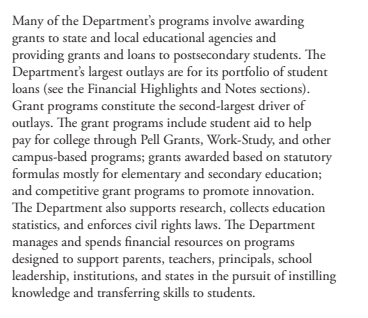

In [78]:
query = "What are the Department of Education's major expenses?"
result = qa({"query": query})
formatter(result)

Waiting
Query: What are the Department of Education's major expenses?
................................................................................
Response: The Department's largest outlays are for its portfolio of student loans (see the Financial Highlights and Notes sections). Grant programs constitute the second-largest driver of outlays. The grant programs include student aid to help pay for college through Pell Grants, Work-Study, and other campus-based programs; grants awarded based on statutory formulas mostly for elementary and secondary education; and competitive grant programs to promote innovation. The Department also supports research, collects education statistics, and enforces civil rights laws.
................................................................................
References: [Document(page_content='grants to state and local educational agencies and providing grants and loans to postsecondary students. The Department’s largest outlays are for its portfolio 

In [79]:
query = "How much amount has been discharged as part of the Public Service Loan Forgiveness program?"
result = qa({"query": query})
formatter(result)

Waiting
Query: How much amount has been discharged as part of the Public Service Loan Forgiveness program?
................................................................................
Response: As of July 31, 2022, the total number of borrowers who received forgiveness from the PSLF waiver exceeded 172,000. The value of this forgiveness totaled $10.5 billion. Including TEPSLF and PSLF discharges not associated with the waiver, the value of forgiveness exceeded $12 billion.
................................................................................
References: [Document(page_content='Public Service Loan Forgiveness (PSLF) program allows a direct loan borrower to have the balance of their direct loans forgiven after having made 120 qualifying monthly payments under a qualifying repayment plan, while working full time for a qualifying public service employer (such as government or certain types of nonprofit organizations). In general, forgiveness provided via PSLF raises the cost

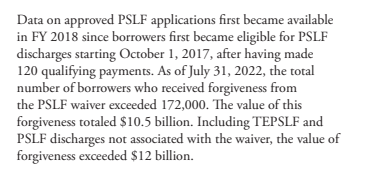

### Configure Question/Answering Chain with Vector Store using Chat

In [80]:
from langchain.chains import RetrievalQA

chat = VertexChat(top_k=20, max_output_tokens=256)

NUMBER_OF_RESULTS = 10

# Expose index to the retriever
retriever = me.as_retriever(
    search_type="similarity",
    search_kwargs={"k": NUMBER_OF_RESULTS})

# Uses LLM to synthesize results from the search index.
# We use Vertex PaLM Chat API for LLM for conversational search
chatqa = RetrievalQA.from_chain_type(
    llm=chat,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=False
)

In [81]:
chat.start_chat('')

In [82]:
chat.history

[]

In [83]:
def formatter(result):
    print(f"Query: {result['query']}")
    print("."*80)
    print(f"Response: {result['result']}")
    if 'source_documents' in result.keys():
      print("."*80)
      print(f"References: {result['source_documents']}")

In [84]:
query = "What are the Department of Education's major expenses?"
result = chatqa({"query": query})
formatter(result)

Waiting
Query: What are the Department of Education's major expenses?
................................................................................
Response: The Department of Education's major expenses are for student loans and grants, which constitute the largest outlays. The grant programs include student aid to help pay for college through Pell Grants, Work-Study, and other campus-based programs; grants awarded based on statutory formulas mostly for elementary and secondary education; and competitive grant programs to promote innovation. The Department also supports research, collects education statistics, and enforces civil rights laws.


In [85]:
query = "How much amount has been discharged as part of the Public Service Loan Forgiveness program ?"
result = chatqa({"query": query})
formatter(result)

Waiting
Query: How much amount has been discharged as part of the Public Service Loan Forgiveness program ?
................................................................................
Response: As of July 31, 2022, the total number of borrowers who received forgiveness from the PSLF waiver exceeded 172,000. The value of this forgiveness totaled $10.5 billion. Including TEPSLF and PSLF discharges not associated with the waiver, the value of forgiveness exceeded $12 billion.


In [86]:
query = "What is the total number of Direct Loan recipients?"
result = qa({"query": query})
formatter(result)

Waiting
Query: What is the total number of Direct Loan recipients?
................................................................................
Response: The total number of Direct Loan recipients is 37.1 million as of September 30, 2022.
................................................................................
References: [Document(page_content='Accrued Interest $ 72.0 $ 83.3 $ 92.1 $ 86.5  $ 86.7 \nAllowance for Subsidy$ (40.7) $ (124.4) $ (216.4) $ (273.9)  $ (611.9)\nTotal No. of Direct Loan Borrowers  (in Millions)34.2 35.1 35.9 37.0 37.1', metadata={}), Document(page_content='than 43 million borrowers. FSA oversees the disbursement of more than $27 billion in grants to more than 6 million recipients.\n11 FSA also oversees approximately 5,600 \npostsecondary institutions that participate in the Federal student aid programs. \nIn FY 2021, FSA performed these functions with \nan administrative budget of $1.9 billion and about 1,400 employees, along with contractors that p

In [87]:
query = "How does number of Direct Loan recipients compare with 2021?"
result = qa({"query": query})
formatter(result)

Waiting
Query: How does number of Direct Loan recipients compare with 2021?
................................................................................
Response: The number of Direct Loan recipients increased from 37.0 million in 2021 to 37.1 million in 2022.
................................................................................
References: [Document(page_content='FY 2022 AGENCY FINANCIAL REPORT U.S. DEPARTMENT OF EDUCATION16\nMANAGEMENT’S DISCUSSION AND ANALYSIS (UNAUDITED)ANALYSIS OF DIRECT LOAN PROGRAM \nRECEIVABLES, NET\nFigure 5 shows the changes in the Direct Loan Program \nreceivable components over the past five years. The principal amount has continued to grow as the Direct Loan Program has originated all new federal loans since July 2010, when originations of new FFEL loans ended. Prior to COVID-19, the rate of increase in principal slowed as enrollment stagnated and sometimes declined. Also, accrued interest amounts had been increasing as more Direct Loans wer

In [88]:
query = "What are the main grant and loan program areas from the Department of Education?"
result = qa(query)
formatter(result)

Waiting
Query: What are the main grant and loan program areas from the Department of Education?
................................................................................
Response: The main grant and loan program areas from the Department of Education are:
- Federal Student Loan Programs
- Pell Grant Program
- William D. Ford Federal Direct Loan Program
- Special Education Grants to States, Individuals with Disabilities Education Act (IDEA) Grants
- Higher Education Act Title IV-A Grants
- Career, Technical, and Adult Education Grants
- Rehabilitation Services Grants
- Institute of Education Sciences Grants
- Hurricane Education Recovery Grants
- Other Grants
................................................................................
References: [Document(page_content='grants to state and local educational agencies and providing grants and loans to postsecondary students. The Department’s largest outlays are for its portfolio of student loans (see the Financial Highlights an

In [89]:
query = "How many students received Pell Grants each year?"
result = qa(query)
formatter(result)

Waiting
Query: How many students received Pell Grants each year?
................................................................................
Response: The number of students who received Pell Grants each year is not mentioned in the document.
................................................................................
References: [Document(page_content='than 43 million borrowers. FSA oversees the disbursement of more than $27 billion in grants to more than 6 million recipients.\n11 FSA also oversees approximately 5,600 \npostsecondary institutions that participate in the Federal student aid programs. \nIn FY 2021, FSA performed these functions with \nan administrative budget of $1.9 billion and about 1,400 employees, along with contractors that provide outsourced business operations. From FY 2017 to FY 2021, FSA delivered an average of $118.9 billion in Federal student aid to an average of 11.4 million students.\n11 Information relating to the amount of the loan portfolio, num

In [90]:
# incorrect response, responds  with total grant expense
query = "How much expense was incurred by Pell Grants?"
result = qa(query)
formatter(result)

Waiting
Query: How much expense was incurred by Pell Grants?
................................................................................
Response: The total expense incurred by Pell Grants was $29,117 million in FY 2022.
................................................................................
References: [Document(page_content='defaulted Perkins loans and for the return of the federal share of schools’ Perkins capital contributions are returned to the T reasury General Fund. (See Note 12)\nTEACH Grant Program. The Department awards \nannual grants of up to $4,000 to eligible undergraduate and graduate students who agree to serve as full-time mathematics, science, foreign language, bilingual education, special education, or reading teachers at high-need schools for four years within eight years of graduation. The maximum lifetime grant for students is $16,000 for undergraduate programs and $8,000 for graduate programs. For students failing to fulfill the service requirement

In [91]:
query = "What are the Department of Education's major challenges in the coming year?"
result = qa({"query": query})
formatter(result)

Waiting
Query: What are the Department of Education's major challenges in the coming year?
................................................................................
Response: The Department of Education's major challenges in the coming year are:
1. Implementing Pandemic Relief Laws
2. Oversight and Monitoring
3. Data Quality and Reporting
4. Improper Payments
5. Information Technology Security
................................................................................
References: [Document(page_content='FY 2022 AGENCY FINANCIAL REPORT U.S. DEPARTMENT OF EDUCATION124\nOTHER INFORMATION (UNAUDITED)UNITED STATES DEPARTMENT OF EDUCATION  \nOFFICE OF INSPECTOR GENERAL  \n  THE INSPECTOR GENERAL  \n400 MARYLAND AVENUE, S.W., WASHINGTON, DC 20202 -1510  \nPromoting the efficiency, effectiveness, and integrity of the Department’s programs and operations.  \nDecember 13, 2022  \nTO: The Honorable Miguel Cardona  \nSecretary of Education  \nFROM:  Sandra D. Bruce  \nInspector General

## Clean Up

Please delete Matching Index and Index Endpoint after running your experiments to avoid incurring additional charges. Please note that you will be charged as long as the endpoint is running.

- Undeploy indexes and Delete index endpoint

In [ ]:
# mengine.delete_index_endpoint()

- Delete index

In [ ]:
# mengine.delete_index()

---

Run only when you want to keep kernel active

In [ ]:
# import time
# print('Keeping kernel active')
# while True:
#   time.sleep(300)
#   print('.', end='')